# Angular Radiation Pressure

Here we will create a model of a Fabry-Perot cavity with its two mirrors suspended from a simple pendulum. We will then drive some angular motions and see how the dynamics of the mirror are altered due to radiation pressure effects. This is commonly referred to in the gravitational community as the HARD and SOFT rotational modes. This refers to the fact that the optical torques modify the two suspension modes makeing one mode harder (higher in resonant frequency) and the other softer (lower in resonant frequency).

First, let us import the various features we will need. For this example, we will use the Python API rather than KatScript as a demonstration.

In [1]:
import cmath
import numpy as np
import finesse
import finesse.components as fc
import finesse.detectors as det
from finesse.analysis.actions import FrequencyResponse

finesse.init_plotting()

Next we build our Fabry-Perot model and attach some simple **Pendulum** dynamics. The pendulum has a resonance at 0.6 Hz and a moment of inertia of 0.757 kg/m$^2$

In [2]:
L = 3994.5 # [m]
I = 0.757  # [kg.m^2]
c = 299792458 # [m.s^-1]
f_sus = 0.6 # [Hz]

model = finesse.Model()
model.fsig.f = 1 # set some initial signal frequency
model.modes(maxtem=1) # first order modes for modelling alignment signals

LASER = model.add(fc.Laser("LASER", P=1000))
# Add two mirrors for the cavity and attach a pendulum mechanics
M1 = model.add(fc.Mirror("M1", R=0.986, T=0.014, Rc=1934))
model.add(
    fc.mechanical.Pendulum(
        "M1_sus", model.M1.mech, mass=np.inf, I_yaw=np.inf, I_pitch=I, fpitch=f_sus
    )
)
M2 = model.add(fc.Mirror("M2", R=1, T=0, Rc=2245))
model.add(
    fc.mechanical.Pendulum(
        "M2_sus", model.M2.mech, mass=np.inf, I_yaw=np.inf, I_pitch=I, fpitch=f_sus
    )
)
model.connect(M1.p1, M2.p1, L=L)
model.connect(LASER.p1, M1.p2)
model.add(fc.Cavity('cavARM', M2.p1.o))
model.add(det.PowerDetector('P', M1.p1.o)); # cavity power

Next we need to analyse the geometry of our cavity and determine how much of each mirror motion makes up HARD and SOFT, this requires computing the $r$ factor.

In [3]:
# Now we compute the decomposition of HARD and SOFT modes into motions of M1 and M2
g_1 = 1 - float(L / np.abs(M1.Rcx.value)) # input mirror g-factor
g_2 = 1 - float(L / np.abs(M2.Rcx.value)) # end mirror g-factor

r = model.add_parameter(
    'r',
    2 / ((g_1 - g_2) + np.sqrt((g_2 - g_1) ** 2 + 4)),
    description='r term in eq.3.5 in T0900511',
)

Above we have added a new parameter to the model using the *model.add_parameter* so that later we can change its value and any other element that uses *model.r* will automatically update itself. This also means we can vary *r* with an action such as *Xaxis* to sweep through different values easily.

Now we can define a new global degree of freedom in the model that combines the local motions of each cavity mirror. Here we use *r.ref* to make a reference to the new parameter we added.

In [4]:
HARD = model.add(fc.DegreeOfFreedom("HARD", M1.dofs.F_pitch, -1, M2.dofs.F_pitch, +r.ref))
SOFT = model.add(fc.DegreeOfFreedom("SOFT", M1.dofs.F_pitch, +r.ref, M2.dofs.F_pitch, +1))

print(HARD.amplitudes)
print(SOFT.amplitudes)

[-1 ❮Symbolic='+r' @ 0x1113f77f0❯]
[❮Symbolic='+r' @ 0x16bd4fa30❯ 1]


We can see our amplitudes now depend on a symbolic reference to *r*. You can see what the current numerical vaue is by simply casting this array to a float type which forces an evaluation of the amplitude.

In [5]:
print("model.r = ", model.r.eval())
print("Current HARD amplutudes:", HARD.amplitudes.astype(float))

model.r =  1.1532419233817137
Current HARD amplutudes: [-1.          1.15324192]


It is worth stopping here to note that we are defining the HARD and SOFT mode to drive a pitch torque by using *M1.dofs.F_pitch*, a **finesse.components.general.LocalDegreeOfFreedom**. A local degree of freedom collects together the static (DC) and small signal (AC) states of an element. In this case it's a degree of freedom that drives a pitch force (or torque, all forces/ torque nodes are prepended with *F_*)

We can see that what this local degree of freedom is outputing is by outputing its AC_IN, AC_OUT, DC attributes.

In [6]:
print(repr(model.M1.dofs.F_pitch.AC_IN))
print(repr(model.M1.dofs.F_pitch.AC_OUT))
print(repr(model.M1.dofs.F_pitch.DC))

❮SignalNode M1.mech.F_pitch @ 0x16bd4f220❯
❮SignalNode M1.mech.pitch @ 0x16bd4f190❯
❮M1.ybeta=((-HARD.DC)+(SOFT.DC*r)) @ 0x16ba19f00❯


The AC_IN defines which signal node will be excited by this Degree of Freedom, for example *HARD.AC.i*. The *AC_OUT* defines which node is used to generate the output of the DOF, *HARD.AC.o.*. The DC attribute definition sets the static state of the static pitch misalignment (in this case, it is the *M1.ybeta*), of the mirror *M1*. By setting the *HARD.DC* value, you can set what the static DOF value is, relative to any *DC* parameter there is on the component itself. ***Check this paragraph***

Using the Python API it is possible to define your own **finesse.components.general.LocalDegreeOfFreedom** and mix and match any DC and AC inputs and outputs as you need. Commonly used ones are typically defined in an elements *.dof* attribute.

Now to continue with the original example, we will set the power to get around 600 kW in the cavity and perform a multiple-unput-multiple-output (MIMO) frequency response analysis exciting the HARD and SOFT mode inputs to their outputs.

In [7]:
LASER.P = 1410 * 3/2 # get to roughly 600kW
freq_resp = FrequencyResponse(
    np.geomspace(0.1, 10, 2000),
    [HARD.AC.i, SOFT.AC.i],
    [HARD.AC.o, SOFT.AC.o],
)
sol = model.run(freq_resp)
# Alsp compute a single data point of the detectors to compute the power
# circulating in the cavity
out = model.run()
print(sol.out.shape)

(2000, 2, 2)


The output of the frequency response analysis is a (2000, 2, 2) array, as we have 2000 frequencies and a 2x2 MIMO matric at each.

We can now plot the results and compare this against equation 2 in [20](http://etheses.bham.ac.uk/6500/9/BrownD16PhD_Final.pdf) which states how much the HARD and SOFT modes are altered by radiation pressure.

Text(0, 0.5, 'Magnitude [dB - rad/Nm]')

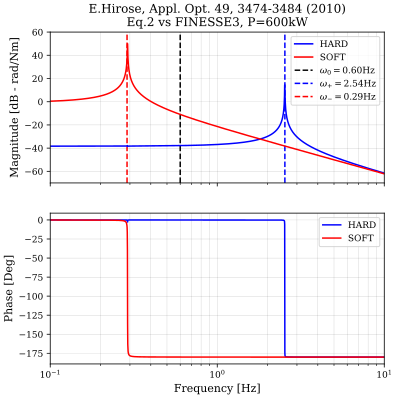

In [8]:
omega_0 = 2 * np.pi * f_sus
P = out['P']
# Eq 2 from https://opg.optica.org/ao/fulltext.cfm?uri=ao-49-18-3474
omega_plus = np.sqrt(
    omega_0**2 + P * L / (I * c) * (-(g_1 + g_2) + cmath.sqrt(4+(g_1 - g_2)**2))/ (1 - g_1*g_2)
)
omega_minus = np.sqrt(
    omega_0**2 + P * L / (I * c) * (-(g_1 + g_2) - cmath.sqrt(4+(g_1 - g_2)**2))/ (1 - g_1*g_2)
)

axs = finesse.plotting.bode(sol.f, sol['HARD.AC.i', 'HARD.AC.o'], label='HARD')
axs = finesse.plotting.bode(sol.f, sol['SOFT.AC.i', 'SOFT.AC.o'], label='SOFT', axs=axs)
axs[0].vlines(omega_0/2/np.pi, -70, 60, ls='--', label=f'$\\omega_{{0}} = {omega_0.real/2/np.pi:0.2f}$Hz', color='k', zorder=-100)
axs[0].vlines(omega_plus.real/2/np.pi, -70, 60, ls='--', label=f'$\\omega_{{+}} = {omega_plus.real/2/np.pi:0.2f}$Hz', zorder=-100)
axs[0].vlines(omega_minus.real/2/np.pi, -70, 60, color='red', ls='--', label=f'$\\omega_{{-}} = {omega_minus.real/2/np.pi:0.2f}$Hz', zorder=-100)
axs[0].margins(0)
axs[0].set_title(f"E.Hirose, Appl. Opt. 49, 3474-3484 (2010)\nEq.2 vs FINESSE3, P={P/1e3:0.0f}kW")
axs[0].legend()
axs[0].set_ylabel("Magnitude [dB - rad/Nm]")

If we reduce the power we can see the opto-mechanical effects are reduced and the HARD and SOFT resonances beginning to return to the nominal suspension resonance frequency.

array([<Axes: ylabel='Magnitude [dB]'>,
       <Axes: xlabel='Frequency [Hz]', ylabel='Phase [Deg]'>],
      dtype=object)

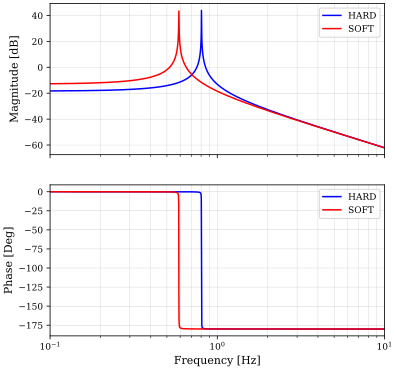

In [9]:
LASER.P = 100
sol = model.run(freq_resp)
axs = finesse.plotting.bode(sol.f, sol['HARD.AC.i', 'HARD.AC.o'], label='HARD')
finesse.plotting.bode(sol.f, sol['SOFT.AC.i', 'SOFT.AC.o'], label='SOFT', axs=axs)

As a last point to make, due to the asymmetric cavity mirror curvatures, the actuation must be properly diagonalised. Here we can see if we simply just set the *M1* and *M2* actuation amplitude to a unit value we now see that when we drive HARD or SOFT we excite the other mode as well.

array([<Axes: ylabel='Magnitude [dB]'>,
       <Axes: xlabel='Frequency [Hz]', ylabel='Phase [Deg]'>],
      dtype=object)

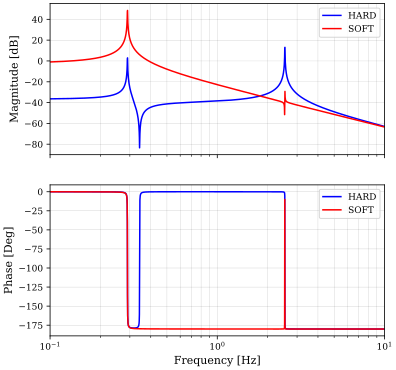

In [10]:
LASER.P = 1410 * 3/2 # get to roughly 600kW
model.r = 1
# Or alternatively you can replace the amplitudes directly with something like
# HARD.amplitudes[:] = [-1, +1]
# SOFT.amplitudes[:] = [+1, +1]
sol = model.run(freq_resp)
axs = finesse.plotting.bode(sol.f, sol['HARD.AC.i', 'HARD.AC.o'], label='HARD')
finesse.plotting.bode(sol.f, sol['SOFT.AC.i', 'SOFT.AC.o'], label='SOFT', axs=axs)